# 5. Exploring genetic algorithms

Let's explore existing genetic algorithms implementations in Python, and then use them in a new third model.

## 5.1. Search

[This Google search was conducted](https://www.google.com/search?q=python+genetic+algorithm&sca_esv=576325651&ei=e3E4ZfXZGLzN1sQPnv-KyAg&ved=0ahUKEwi1g-WMiJCCAxW8ppUCHZ6_AokQ4dUDCBA&uact=5&oq=python+genetic+algorithm&gs_lp=Egxnd3Mtd2l6LXNlcnAiGHB5dGhvbiBnZW5ldGljIGFsZ29yaXRobTIFEAAYgAQyBRAAGIAEMgYQABgHGB4yBhAAGAcYHjIGEAAYBxgeMgYQABgHGB4yBhAAGAcYHjIEEAAYHjIEEAAYHjIEEAAYHkjkEVCAC1iMDnABeAGQAQCYAYgBoAHlBaoBAzAuNrgBA8gBAPgBAcICChAAGEcY1gQYsAPiAwQYACBBiAYBkAYI&sclient=gws-wiz-serp) on 2023-10-24. The following libraries were found:

* [PyGAD](https://pygad.readthedocs.io/en/latest/)
* [geneticalgorithm](https://pygad.readthedocs.io/en/latest/)

**The first one seems to be more complete**. Let's try it.

## 5.2. Exploring

The next cells are simply replicating the step-by-step tutorial available [here](https://pygad.readthedocs.io/en/latest/).

As a supporting material, we also have [this article](https://www.linkedin.com/pulse/genetic-algorithm-implementation-python-ahmed-gad/), which was found on [the main github repository](https://github.com/ahmedfgad/GeneticAlgorithmPython).

In [8]:
import pygad
import numpy as np

In [9]:
function_inputs = [4,-2,3.5,5,-11,-4.7]
desired_output = 44

In [10]:
def fitness_func(ga_instance, solution, solution_idx):
    output = np.sum(solution*function_inputs)
    fitness = 1.0 / np.abs(output - desired_output)
    return fitness

In [11]:
fitness_function = fitness_func

num_generations = 50
num_parents_mating = 6

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

In [12]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

In [13]:
ga_instance.run()

In [14]:
ga_instance.best_solution()

(array([ 5.24680389,  2.69237915,  2.0472913 ,  2.13605876, -0.93215016,
        -0.06155446]),
 114.00285328618179,
 0)

In [15]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

prediction = np.sum(np.array(function_inputs)*solution)
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

Parameters of the best solution : [ 5.24680389  2.69237915  2.0472913   2.13605876 -0.93215016 -0.06155446]
Fitness value of the best solution = 114.00285328618179
Predicted output based on the best solution : 43.99122828972105


No handles with labels found to put in legend.


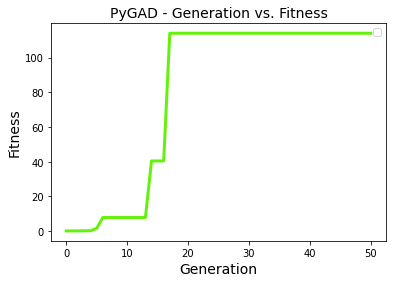

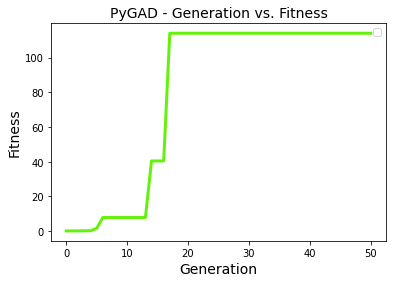

In [16]:
ga_instance.plot_fitness()

## 5.3. Doing the model

Ok, the code seems simple enough. Let's try to implement it in our model.

In [17]:
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.dataset import load_dataset
from sklearn.svm import SVC
from typing import List, Any, Dict
import numpy as np
import sklearn.metrics as metrics
import pandas as pd
from sklearn.feature_selection import f_classif


In [18]:
train_data = load_dataset("scene", "train")
test_data = load_dataset("scene", "test")
# let's use the same "scene" dataset, that was used in the previous notebook (`1_first_model_experiments.ipynb`)

X_train, y_train, _, _ = train_data
X_test, y_test, _, _ = test_data

classifier = ClassifierChain(
    classifier=SVC(),
    require_dense=[False, True]
)

classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

baseline_cc_accuracy = metrics.accuracy_score(y_test, predictions)
baseline_cc_hamming_loss = metrics.hamming_loss(y_test, predictions)

print("Accuracy score: ", baseline_cc_accuracy)
print("Hamming loss: ", 1/(baseline_cc_hamming_loss+0.05))

scene:train - exists, not redownloading
scene:test - exists, not redownloading
Accuracy score:  0.6780936454849499
Hamming loss:  7.099327265532251


In [19]:
X_train, y_train, _, _ = train_data
X_test, y_test, _, _ = test_data

labels_count = y_test.shape[1]

def has_duplicates(int_list):
    seen = set()
    for num in int_list:
        if num in seen:
            return True
        seen.add(num)
    return False

def has_negatives(int_list):
    for num in int_list:
        if num < 0:
            return True
    return False

def test_ordering(order: List[int]) -> float:
    print(f"testing order: {order}")

    classifier = ClassifierChain(
        classifier=SVC(),
        require_dense=[False, True],
        order=order,
    )

    classifier.fit(X_train, y_train)
    preds = classifier.predict(X_test)

    hamming_loss = metrics.hamming_loss(
        y_test, preds)

    return hamming_loss


In [20]:
def model_fitness_func(ga_instance, solution, solution_idx):
    if has_duplicates(solution):
        print("solutions contains duplicated values, skipping")
        return 0
    
    if has_negatives(solution):
        print("solutions contains negative values, skipping")
        return 0

    hamming_loss = test_ordering(solution)
    return 1/hamming_loss
    # this will be the fitness function result, and we want to maximize it
    # therefore, we have to return the inverse of the hamming loss

ga_model = pygad.GA(
    gene_type=int,
    gene_space=[0,1,2,3,4,5], # TODO should be set from the label space
    random_seed=42,
    save_best_solutions=False,
    fitness_func=model_fitness_func,
    allow_duplicate_genes=False, # very important, otherwise we will have duplicate labels in the ordering
    num_genes=labels_count,

    # set up
    num_generations=10,
    num_parents_mating=2,
    sol_per_pop=4,

    # following what the article describes
    keep_elitism=1, # also following what the article describes, but we have to double check [TODO]
    parent_selection_type="rws", # following what the article describes
    # mutation_probability=0.005, # following what the article describes

    # TODO let's check how the article defines this
    crossover_type="scattered",
    mutation_type="random",
    mutation_by_replacement=True,
    mutation_num_genes=1,
)

In [21]:
ga_model.run()

testing order: [3 4 2 0 5 1]
testing order: [2 5 1 4 3 0]
testing order: [5 4 1 3 0 2]
testing order: [1 3 4 0 2 5]
testing order: [2 1 5 3 0 4]
testing order: [2 5 1 4 0 3]
testing order: [2 3 1 4 0 5]
testing order: [2 1 0 3 4 5]
testing order: [2 1 5 0 3 4]
testing order: [4 1 5 0 2 3]
testing order: [2 1 5 0 4 3]
testing order: [1 2 5 0 3 4]
testing order: [2 1 3 0 5 4]
testing order: [2 3 5 0 1 4]
testing order: [2 3 5 0 1 4]
testing order: [2 3 0 1 4 5]
testing order: [2 0 3 5 1 4]
testing order: [2 5 0 3 4 1]
testing order: [2 4 0 3 1 5]
testing order: [0 1 2 3 4 5]
testing order: [2 1 0 5 4 3]


In [22]:
solution, solution_fitness, solution_idx = ga_model.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

testing order: [2 1 0 5 4 3]
Parameters of the best solution : [0 1 2 3 4 5]
Fitness value of the best solution = 11.006134969325153


In [23]:
test_ordering([2, 1, 0, 5, 4, 3])

testing order: [2, 1, 0, 5, 4, 3]


0.2467948717948718

In [24]:
test_ordering([0, 1, 2, 3, 4, 5])

testing order: [0, 1, 2, 3, 4, 5]


0.09085841694537347